# Potential Plot
> - Extension following Oleg's discussion on 2020-06-28

Minimization of the following:

$$
\bar{u}_\text{pot} = \frac{U}{E_J} = -\big[ \alpha\cos(\varphi_{02}) + \cos(\varphi_{03}) + \cos(\varphi_{01}) + \\
+ \cos(\varphi_{02} - \varphi_{01} - L) + \cos(\varphi_{02} - \varphi_{03} + R)\big]
$$

In [1]:
import math
import itertools
from collections import defaultdict

pi = math.pi

import numpy as np
from numba import cuda
from numba.cuda.cudadrv.devicearray import DeviceNDArray
import matplotlib.pyplot as plt
plt.style.use('my_official')

from functions.potential import potential_function_cuda
from kernels.potential_evaluator import PotentialEvaluator
from kernels.potential_minimum_searcher import PotentialMinimumSearcher
from utils.array_stacker import ArrayStacker

# Parameters of the simulation

In [2]:
NUMBER_OF_PHI_POINTS = 150
NUMBER_OF_FIELD_POINTS = 50
NUMBER_OF_FIELD_POINTS_PER_RUN = 10
NUMBER_OF_FIELD_RUNS = (
    NUMBER_OF_FIELD_POINTS - 1
) // NUMBER_OF_FIELD_POINTS_PER_RUN + 1
ALPHA = 1
LOWER = -0.5
UPPER = 1.5

lr_array = np.linspace(LOWER * 2 * pi, UPPER * 2 * pi, NUMBER_OF_FIELD_POINTS)
phixx_array = np.linspace(-pi, pi, NUMBER_OF_PHI_POINTS)

# Create kernels to cuda

In [3]:
BLOCKS_PER_GRID = (NUMBER_OF_FIELD_POINTS_PER_RUN, NUMBER_OF_FIELD_POINTS_PER_RUN)

potential_evaluator = PotentialEvaluator(NUMBER_OF_PHI_POINTS, potential_function_cuda)
THREADS_PER_BLOCK_potential_evaluation = potential_evaluator.allocate_max_threads(8)

potential_minimum_searcher = PotentialMinimumSearcher(NUMBER_OF_PHI_POINTS)
THREADS_PER_BLOCK_potential_search = potential_minimum_searcher.allocate_max_threads()

🐳 Allocating           THREADS_PER_BLOCK = (8, 8, 8)
🐳 Allocating           THREADS_PER_BLOCK = (32, 32)


# Execution
- Allocate arrays on GPU
- As we split the field up into quadrants, create a quadrant array that will stitch fields together

In [4]:
DEVICE_lr_array = cuda.to_device(lr_array)
DEVICE_phixx_array = cuda.to_device(phixx_array)
DEVICE_potential_array = cuda.device_array(
    shape=(
        NUMBER_OF_FIELD_POINTS_PER_RUN,
        NUMBER_OF_FIELD_POINTS_PER_RUN,
        NUMBER_OF_PHI_POINTS,
        NUMBER_OF_PHI_POINTS,
        NUMBER_OF_PHI_POINTS,
    ),
    dtype=np.float32,
)
DEVICE_grid_search_result_array = cuda.device_array(
    shape=(NUMBER_OF_FIELD_POINTS_PER_RUN, NUMBER_OF_FIELD_POINTS_PER_RUN, 4),
    dtype=np.float32,
)

# Go through teach of the field section and evaluate ##########################
quadrants = defaultdict(lambda: [[None] * NUMBER_OF_FIELD_RUNS for i in range(0, NUMBER_OF_FIELD_RUNS)])
for (L_RUN, R_RUN) in itertools.product(
    range(0, NUMBER_OF_FIELD_RUNS), range(0, NUMBER_OF_FIELD_RUNS)
):
    print(
        f"🦑 Running (L={L_RUN}/{NUMBER_OF_FIELD_RUNS - 1}), (R={R_RUN}/{NUMBER_OF_FIELD_RUNS - 1})"
    )
    L_OFFSET = int(L_RUN * NUMBER_OF_FIELD_POINTS_PER_RUN)
    R_OFFSET = int(R_RUN * NUMBER_OF_FIELD_POINTS_PER_RUN)
    potential_evaluator.kernel[BLOCKS_PER_GRID, THREADS_PER_BLOCK_potential_evaluation](
        DEVICE_phixx_array,
        DEVICE_lr_array,
        L_OFFSET,
        R_OFFSET,
        ALPHA,
        DEVICE_potential_array,
    )
    potential_minimum_searcher.kernel[
        BLOCKS_PER_GRID, THREADS_PER_BLOCK_potential_search
    ](DEVICE_potential_array, DEVICE_grid_search_result_array)
    
    grid_search_result_array = DEVICE_grid_search_result_array.copy_to_host()
    quadrants["potential"][L_RUN][R_RUN] = grid_search_result_array[:,:,0]
    quadrants["phi01"][L_RUN][R_RUN] = phixx_array[grid_search_result_array[:,:,1].astype(int)] / (2 * pi)
    quadrants["phi02"][L_RUN][R_RUN] = phixx_array[grid_search_result_array[:,:,2].astype(int)] / (2 * pi)
    quadrants["phi03"][L_RUN][R_RUN] = phixx_array[grid_search_result_array[:,:,3].astype(int)] / (2 * pi)

🦑 Running (L=0/4), (R=0/4)
🦑 Running (L=0/4), (R=1/4)
🦑 Running (L=0/4), (R=2/4)
🦑 Running (L=0/4), (R=3/4)
🦑 Running (L=0/4), (R=4/4)
🦑 Running (L=1/4), (R=0/4)
🦑 Running (L=1/4), (R=1/4)
🦑 Running (L=1/4), (R=2/4)
🦑 Running (L=1/4), (R=3/4)
🦑 Running (L=1/4), (R=4/4)
🦑 Running (L=2/4), (R=0/4)
🦑 Running (L=2/4), (R=1/4)
🦑 Running (L=2/4), (R=2/4)
🦑 Running (L=2/4), (R=3/4)
🦑 Running (L=2/4), (R=4/4)
🦑 Running (L=3/4), (R=0/4)
🦑 Running (L=3/4), (R=1/4)
🦑 Running (L=3/4), (R=2/4)
🦑 Running (L=3/4), (R=3/4)
🦑 Running (L=3/4), (R=4/4)
🦑 Running (L=4/4), (R=0/4)
🦑 Running (L=4/4), (R=1/4)
🦑 Running (L=4/4), (R=2/4)
🦑 Running (L=4/4), (R=3/4)
🦑 Running (L=4/4), (R=4/4)


## Accumulate results
- Collect up results
- Plot

In [6]:
result = {}
for key, value in quadrants.items():
    print(f"🦑--------------------{key}--------------------")
    result[key] = ArrayStacker.stack_into_square(value)
print(result["potential"])

🦑--------------------potential--------------------
🦑--------------------phi01--------------------
🦑--------------------phi02--------------------
🦑--------------------phi03--------------------
[[3.7503917 3.5060625 3.2732792 ... 3.2732792 3.5060625 3.7503917]
 [3.6416993 3.4027705 3.176096  ... 3.4028053 3.64158   3.6416993]
 [3.5640454 3.3314278 3.1128476 ... 3.5638413 3.8070552 3.5640454]
 ...
 [3.5640454 3.8070552 3.5638413 ... 3.1128476 3.3314278 3.5640454]
 [3.6416993 3.64158   3.4028053 ... 3.176096  3.4027705 3.6416993]
 [3.7503917 3.5060625 3.2732792 ... 3.2732792 3.5060625 3.7503917]]


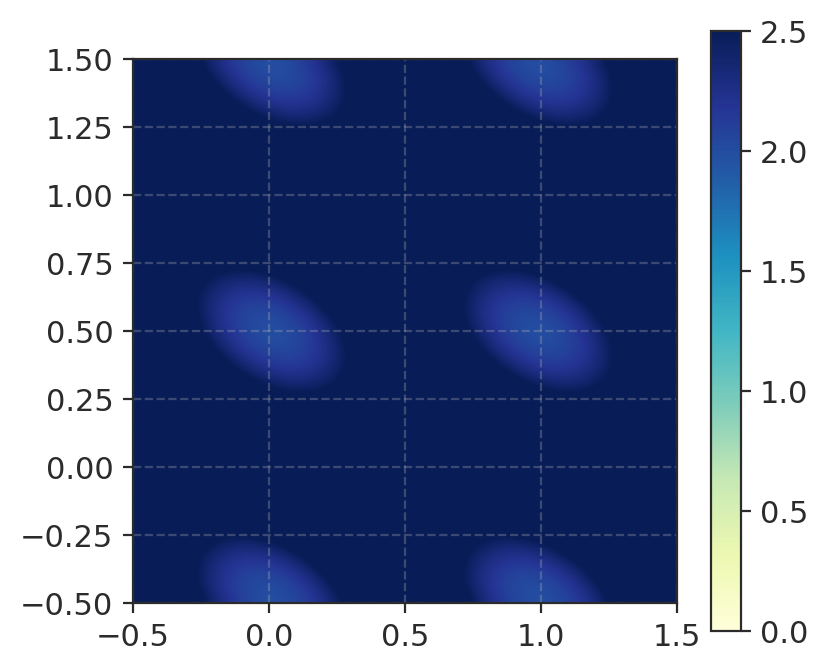

In [18]:

fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(4, 4))

im = ax.imshow(
    # result["potential"],
    result["potential"],
    extent = [LOWER, UPPER, LOWER, UPPER],
    origin= 'lower',
    #cmap='summer',
    cmap='YlGnBu',
    interpolation='spline36',
    vmin=0, vmax=2.5
)
cbar = fig.colorbar(im)
cbar.set_ticks([0, 0.5, 1, 1.5, 2, 2.5])

In [13]:
type(cbar)

matplotlib.colorbar.Colorbar